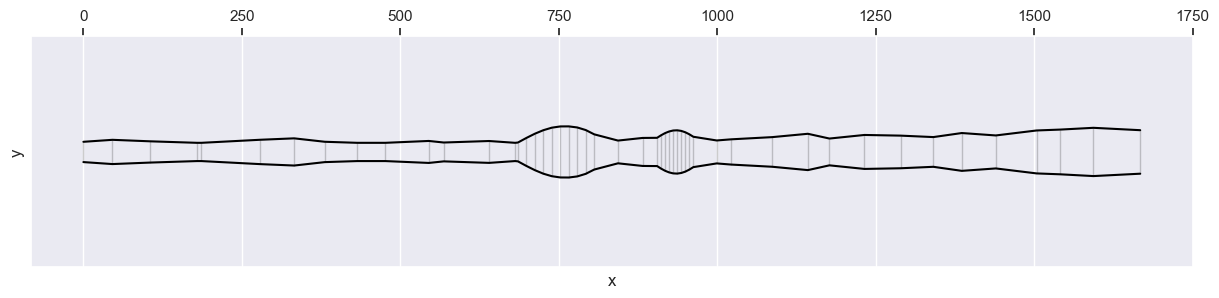

In [1]:
import sys
sys.path.append("../")
import numpy as np
from didgelab.calc.geo import Geo
from didgelab.util.didge_visualizer import vis_didge
from didgelab.evo.nuevolution import GeoGenome

class WebShape(GeoGenome):

    def __init__(
        self,
        n_segments = 4, 
        d0=32, 
        d_bell_min=50, 
        d_bell_max=80,
        max_length = 1900, 
        min_length = 1500,
        n_bubbles=0,
        smoothness = 0.3):

        self.max_length = max_length
        self.min_length = min_length
        self.n_segments = n_segments
        self.d0 = d0
        self.d_bell_min = d_bell_min
        self.d_bell_max = d_bell_max
        self.n_bubbles = n_bubbles
        self.smoothness = smoothness

        self.geo_offset = 3 + self.n_bubbles*3
        genome_length = 3+2*(n_segments-1) + self.n_bubbles*3
        self.n_bubble_segments = 10

        GeoGenome.__init__(self, n_genes = genome_length)

    def get_properties(self):
        length = self.genome[0] * (self.max_length-self.min_length) + self.min_length
        bell_size = self.genome[1] * (self.d_bell_max - self.d_bell_min) + self.d_bell_min
        power = self.genome[2]*4

        bubbles = []
        j=3
        for i in range(self.n_bubbles):
            pos = self.genome[j] * length
            width = 150*self.genome[j+1]
            height = self.genome[j+2]*40
            j+=3
            bubbles.append((pos, width, height))
            
        x_genome = np.array([self.genome[i] for i in range(self.geo_offset, len(self.genome), 2)])
        y_genome = np.array([self.genome[i] for i in range(self.geo_offset+1, len(self.genome), 2)])

        return length, bell_size, power, x_genome, y_genome, bubbles

    def genome2geo(self):
        length, bell_size, power, x_genome, y_genome, bubbles = self.get_properties()

        x = np.arange(0, 1, 1/(self.n_segments+1)) * length
        y = np.arange(0, 1, 1/(self.n_segments+1))
        y = np.power(y, power)
        
        y = y * (bell_size-self.d0) + self.d0

        shift_x = length / self.n_segments
        x += np.concatenate(([0], (x_genome-0.5)*shift_x, [0]))

        shift_y = (1-self.smoothness)*bell_size
        y += np.concatenate(([0], (y_genome-0.5)*shift_y, [0]))

        x, y = self.fix_didge(x,y,self.d0, bell_size)

        for bubble in bubbles:
            pos, width, height = bubble
            x, y = self.make_bubble(x, y, pos, width, height)

        geo = list(zip(x,y))
        return Geo(geo)

    
    def fix_didge(self, x,y, d0, bellsize):
        mind = d0*0.9
        x=x.copy()
        y=y.copy()
        y[y<mind] = mind
        maxd = bellsize*1.3
        y[y>maxd] = maxd
        return x,y

    def make_bubble(self, x, y, pos, width, height):
        
        bubble_start_x = pos-0.5*width
        bubble_end_x = pos+0.5*width

        if bubble_start_x < 20:
            diff = 20-bubble_start_x
            bubble_start_x += diff
            bubble_end_x += diff

        if bubble_end_x > x[-1]:
            diff = bubble_end_x-x[-1]
            bubble_start_x -= diff
            bubble_end_x -= diff

        bubble_x = np.arange(bubble_start_x, bubble_end_x, (bubble_end_x-bubble_start_x)/self.n_bubble_segments)

        geo = Geo(list(zip(x,y)))
        bubble_y_1 = np.array([geo.diameter_at_x(i) for i in bubble_x])
        bubble_y_2 = height*np.sin(np.pi*np.arange(self.n_bubble_segments)/self.n_bubble_segments)
        bubble_y = bubble_y_1 + bubble_y_2

        y = np.concatenate((y[x<bubble_start_x], bubble_y, y[x>bubble_end_x]))
        x = np.concatenate((x[x<bubble_start_x], bubble_x, x[x>bubble_end_x]))

        return x, y
    
np.random.seed(0)
shape = WebShape(n_segments=32, smoothness=0.7, n_bubbles=2)
geo = shape.genome2geo()
vis_didge(geo)